In [193]:
# %pip install -q google-cloud-aiplatform

In [194]:
# SDKを最新化
# %pip install -U google-cloud-aiplatform

In [195]:
# IDを確認
!curl -H "Metadata-Flavor: Google" \
  http://metadata.google.internal/computeMetadata/v1/project/project-id

gen-lang-client-0058650976

In [196]:
#  Vertex AI 関連（aiplatform.googleapis.com） が有効かを確認
!gcloud services list --enabled --project gen-lang-client-0058650976 | grep AI

aiplatform.googleapis.com            Vertex AI API


In [197]:
from vertexai import init
from vertexai.generative_models import GenerativeModel

# プロジェクトは "ID" を入れる（例: gen-lang-client-xxxxx）
init(project="gen-lang-client-0058650976", location="asia-northeast1") 

# まずは入手性が広い 2.5 Flash を試す
model = GenerativeModel("gemini-2.5-flash")
print(model.generate_content("疎通テスト").text)

/opt/conda/lib/python3.10/site-packages/vertexai/generative_models/_generative_models.py:433: UserWarning: This feature is deprecated as of June 24, 2025 and will be removed on June 24, 2026. For details, see https://cloud.google.com/vertex-ai/generative-ai/docs/deprecations/genai-vertexai-sdk.
  warning_logs.show_deprecation_warning()


はい、聞こえています。何かお手伝いできることはありますか？


## 🧩 確認できること
- Vertex AI SDK が正しく使える
- 認証済みのプロジェクトに接続できている
- モデル呼び出し（Gemini 2.5 Flash）が通る

## データ読み込み開始
- GCS（Google Cloud Storage）のパスを使用  
- GCSストレージ上のファイルを直接読み込み・保存

In [198]:
import gcsfs

fs = gcsfs.GCSFileSystem()
files = fs.glob("gs://rag-practice-bucket/**/*.parquet")
files

['rag-practice-bucket/part-00000-5d0b89f1-3d52-4ae2-b5da-dd18305c5173-c000.snappy.parquet',
 'rag-practice-bucket/part-00000-7bf08c82-b8bf-4a93-a28f-4789185354c4-c000.snappy.parquet',
 'rag-practice-bucket/part-00000-f07624b2-401d-4bc3-ade0-a8ae982c58b5-c000.snappy.parquet',
 'rag-practice-bucket/part-00001-5d0b89f1-3d52-4ae2-b5da-dd18305c5173-c000.snappy.parquet']

In [199]:
import pandas as pd

bucket = "gs://rag-practice-bucket"

# 1. コメントデータ（2ファイル）
comments_1 = pd.read_parquet(f"{bucket}/part-00000-5d0b89f1-3d52-4ae2-b5da-dd18305c5173-c000.snappy.parquet")
comments_2 = pd.read_parquet(f"{bucket}/part-00001-5d0b89f1-3d52-4ae2-b5da-dd18305c5173-c000.snappy.parquet")

# 2. 動画メタ
video_df = pd.read_parquet(f"{bucket}/part-00000-7bf08c82-b8bf-4a93-a28f-4789185354c4-c000.snappy.parquet")

# 3. チャンネルメタ
channel_df = pd.read_parquet(f"{bucket}/part-00000-f07624b2-401d-4bc3-ade0-a8ae982c58b5-c000.snappy.parquet")

# 確認
print("comments_1:", comments_1.shape)
print("comments_2:", comments_2.shape)
print("video_df:", video_df.shape)
print("channel_df:", channel_df.shape)

comments_1: (4194, 6)
comments_2: (4201, 6)
video_df: (686, 9)
channel_df: (1, 6)


## 必要な前処理（ローカルでの処理と同様）

In [200]:
comments_df = pd.concat([comments_1, comments_2], ignore_index=True)

print(comments_df.shape)

(8395, 6)


In [201]:
video_comment_df = video_df.merge(comments_df, on="video_id", how="left")
print(video_comment_df.shape)
video_comment_df.head()

(8981, 14)


,video_id,title,published_at_x,view_count,like_count_x,comment_count,duration,tags,total_seconds,comment_id,author_display_name,published_at_y,text_display,like_count_y
0,--CI9Gndvwc,スキマスイッチ「SUKIMASWITCH 20th Anniversary BEST 『PO...,2023-05-12 03:00:00,17404,493,27,PT2M27S,,147,NaN,NaN,NaT,NaN,NaN
1,-0TkcSGovqI,#奥田民生 × #スキマスイッチ と #ヴィンテージ #ギター の世界へ！,2022-03-23 03:09:43,6874,269,1,PT47S,,47,NaN,NaN,NaT,NaN,NaN
2,-29NR48c_Dk,#本日の全力少年＠大分県・別府ビーコンプラザ,2025-02-20 15:51:55,3477,198,5,PT1M10S,,70,NaN,NaN,NaT,NaN,NaN
3,-7_No7g0oa4,【公式】#86 好評企画！第3回『大橋CASINO』 開催！ピンチをチャンスへ！ スキマスイ...,2022-12-23 10:00:00,27684,890,54,PT13M2S,"スキマスイッチ,SUKIMASWITCH,スキマ,大橋卓弥,大橋,常田真太郎,常田,奏,全力...",782,NaN,NaN,NaT,NaN,NaN
4,-7nRNRSy0gI,スキマスイッチ「view」副音声付（from スキマスイッチ 2004ファーストツアー “夏...,2022-11-02 09:00:00,22970,754,50,PT4M22S,,262,NaN,NaN,NaT,NaN,NaN


In [202]:
video_comment_df = video_comment_df.dropna(subset=["text_display"]).reset_index(drop=True)
print(video_comment_df.shape)

(8395, 14)


In [203]:
import re

# ① パターンを事前コンパイル（速い＆見通し）
TAG_BLOCK   = re.compile(r"[『【\(（][^】』\)）]{1,40}[】』\)）]")  # 『タイトル』や【MV】（40字は適当に）
URL         = re.compile(r"http\S+")
HTML        = re.compile(r"<.*?>")
HASHTAG     = re.compile(r"#\S+")
MENTION     = re.compile(r"@[A-Za-z0-9_]+")
ARTIST_SLASH= re.compile(r"\bスキマスイッチ\s*/\s*[^ ]+")        # 「スキマスイッチ / 曲名」
PROMO       = re.compile(r"チャンネル登録|高評価|配信中|公開中|コメントしてね")

# ※ YouTube風タイムスタンプ（お好みで）
TS = re.compile(r"(?:\b|\s)(?:\d{1,2}:){1,2}\d{2}(?:\s*[-–—~〜]\s*(?:\d{1,2}:){1,2}\d{2})?")

def clean_text(s: str) -> str:
    if not isinstance(s, str):
        return ""
    # 全角コロン/空白の正規化
    s = s.replace("：", ":").replace("　", " ")

    # ② 削除系
    s = HTML.sub(" ", s)
    s = URL.sub(" ", s)
    s = HASHTAG.sub(" ", s)
    s = MENTION.sub(" ", s)
    s = TAG_BLOCK.sub(" ", s)       # 『…』や【…】の囲み
    s = ARTIST_SLASH.sub(" ", s)    # 「スキマスイッチ / …」
    s = PROMO.sub(" ", s)
    s = TS.sub(" ", s)              # タイムスタンプ

    # ③ 余白整形
    s = re.sub(r"\s+", " ", s).strip()
    return s


# 適用
video_comment_df["clean_text"] = video_comment_df["text_display"].apply(clean_text)
video_comment_df.columns

Index(['video_id', 'title', 'published_at_x', 'view_count', 'like_count_x',
       'comment_count', 'duration', 'tags', 'total_seconds', 'comment_id',
       'author_display_name', 'published_at_y', 'text_display', 'like_count_y',
       'clean_text'],
      dtype='object')

In [204]:
# 空文字 or 空白だけの行をカウント
empty_count = (video_comment_df["clean_text"].astype(str).str.strip() == "").sum()

# NaN の数も別で確認
nan_count = video_comment_df["clean_text"].isna().sum()

print(f"空文字行: {empty_count}")
print(f"NaN行: {nan_count}")

空文字行: 13
NaN行: 0


In [205]:
# 空文字行を削除
video_comment_df = video_comment_df[
    video_comment_df["clean_text"].astype(str).str.strip() != ""
].dropna(subset=["clean_text"])

In [206]:
# 空文字 or 空白だけの行をカウント
empty_count = (video_comment_df["clean_text"].astype(str).str.strip() == "").sum()

# NaN の数も別で確認
nan_count = video_comment_df["clean_text"].isna().sum()

print(f"空文字行: {empty_count}")
print(f"NaN行: {nan_count}")

空文字行: 0
NaN行: 0


## Vertex AIを用いた大規模テキスト埋め込み生成
- Vertex AI 上でテキスト埋め込み（text-embedding-004）を実行。
- ローカル環境でのベクトル生成処理をクラウドAPI経由に置き換え、
- 大規模データ（約8,400件）をバッチ処理（250件単位）で安定的にEmbedding化。

In [207]:
from vertexai.language_models import TextEmbeddingModel
import numpy as np

embed = TextEmbeddingModel.from_pretrained("text-embedding-004")
texts = video_comment_df["clean_text"].astype(str).tolist()

embeddings = []
for i in range(0, len(texts), 250):
    batch = texts[i:i+250]
    result = embed.get_embeddings(batch)
    embeddings.extend(result)
    print(f"Processed: {i+len(batch)} / {len(texts)}")

emb_matrix = np.array([e.values for e in embeddings], dtype=np.float32)
print("Embedding shape:", emb_matrix.shape)

/opt/conda/lib/python3.10/site-packages/vertexai/_model_garden/_model_garden_models.py:278: UserWarning: This feature is deprecated as of June 24, 2025 and will be removed on June 24, 2026. For details, see https://cloud.google.com/vertex-ai/generative-ai/docs/deprecations/genai-vertexai-sdk.
  warning_logs.show_deprecation_warning()


Processed: 250 / 8382
Processed: 500 / 8382
Processed: 750 / 8382
Processed: 1000 / 8382
Processed: 1250 / 8382
Processed: 1500 / 8382
Processed: 1750 / 8382
Processed: 2000 / 8382
Processed: 2250 / 8382
Processed: 2500 / 8382
Processed: 2750 / 8382
Processed: 3000 / 8382
Processed: 3250 / 8382
Processed: 3500 / 8382
Processed: 3750 / 8382
Processed: 4000 / 8382
Processed: 4250 / 8382
Processed: 4500 / 8382
Processed: 4750 / 8382
Processed: 5000 / 8382
Processed: 5250 / 8382
Processed: 5500 / 8382
Processed: 5750 / 8382
Processed: 6000 / 8382
Processed: 6250 / 8382
Processed: 6500 / 8382
Processed: 6750 / 8382
Processed: 7000 / 8382
Processed: 7250 / 8382
Processed: 7500 / 8382
Processed: 7750 / 8382
Processed: 8000 / 8382
Processed: 8250 / 8382
Processed: 8382 / 8382
Embedding shape: (8382, 768)


## BigQueryへの保存準備

In [217]:
# 埋め込みベクトルとテキストをまとめてDataFrame化
import pandas as pd

emb_df = pd.DataFrame(emb_matrix, columns=[f"{i:03d}" for i in range(emb_matrix.shape[1])])
emb_df["clean_text"] = video_comment_df["clean_text"].values

print(emb_df.shape)
emb_df.head(n=10) #768次元の数値ベクトル

(8382, 769)


,000,001,002,003,004,005,006,007,008,009,...,759,760,761,762,763,764,765,766,767,clean_text
0,-0.012862,0.035311,-0.016032,0.009965,0.037534,0.019123,0.036059,-0.030223,0.055315,0.031343,...,0.019433,-0.025288,0.067014,-0.014390,0.011361,-0.047483,0.008419,0.044302,-0.014375,「&quot;積み上げてる物ぶっ壊れてる&quot;状態」 歌詞もネタにいれてくれてるのいいなぁ
1,-0.010466,0.037911,0.007222,0.018221,0.052334,0.033693,0.056397,-0.021193,0.036049,0.006381,...,0.030722,-0.010426,0.042456,-0.015418,0.027413,-0.071110,0.021789,0.031014,-0.022321,でも俺らも「スキマスイッチ」という名前使ってお金稼いでるっていうオチかとおもった。が、私もま...
2,-0.010466,0.037911,0.007222,0.018221,0.052334,0.033693,0.056397,-0.021193,0.036049,0.006381,...,0.030722,-0.010426,0.042456,-0.015418,0.027413,-0.071110,0.021789,0.031014,-0.022321,演歌の大御所なんかためで曲の長さが変わっちゃう。
3,-0.010466,0.037911,0.007222,0.018221,0.052334,0.033693,0.056397,-0.021193,0.036049,0.006381,...,0.030722,-0.010426,0.042456,-0.015418,0.027413,-0.071110,0.021789,0.031014,-0.022321,ラパルフェわろ
4,-0.010466,0.037911,0.007222,0.018221,0.052334,0.033693,0.056397,-0.021193,0.036049,0.006381,...,0.030722,-0.010426,0.042456,-0.015418,0.027413,-0.071110,0.021789,0.031014,-0.022321,さや香さん面白い😆👏来週のアレンジ歌唱めちゃくちゃ楽しみ🤣🎤
5,-0.002858,0.021110,-0.010024,0.010042,0.019692,0.045088,0.049800,-0.020083,0.025345,-0.000388,...,0.015179,-0.002856,0.069775,-0.016856,0.006150,-0.068611,0.020360,0.054558,-0.025202,さや香よりスキマスイッチのが見た目漫才師っぽい😂ほんでこの番組は何でそんなにカメラの数が多いの？
6,-0.010466,0.037911,0.007222,0.018221,0.052334,0.033693,0.056397,-0.021193,0.036049,0.006381,...,0.030722,-0.010426,0.042456,-0.015418,0.027413,-0.071110,0.021789,0.031014,-0.022321,スキマスイッチネタがとっても嬉しいです🩵
7,-0.027997,0.020212,-0.035204,-0.011087,0.031888,0.023008,0.046671,-0.016841,0.044015,0.026719,...,0.037364,0.005776,0.093404,-0.054734,0.017838,-0.049389,-0.008815,0.051010,0.006327,さや香とスキマスイッチという神コラボ！おもしろくてずっと見てられる！！
8,-0.010466,0.037911,0.007222,0.018221,0.052334,0.033693,0.056397,-0.021193,0.036049,0.006381,...,0.030722,-0.010426,0.042456,-0.015418,0.027413,-0.071110,0.021789,0.031014,-0.022321,ラパルフェ
9,0.033339,0.018275,-0.017907,0.032502,0.012951,0.034217,0.098303,-0.009720,0.021192,0.002928,...,0.015071,-0.032923,0.010235,0.006198,0.016492,-0.046668,-0.006261,0.014559,0.008163,ゆずは漫才師というよりどぶろっくやテツandトモのような芸人がチラついてしまう


## BigQuery への埋め込みデータ保存

In [209]:
from pandas_gbq import to_gbq

project_id = "gen-lang-client-0058650976"
table_id = "rag_embeddings.comments_embeddings"

to_gbq(
    emb_df,
    destination_table=table_id,
    project_id=project_id,
    if_exists="replace"
)

100%|██████████| 1/1 [00:00<00:00, 2863.01it/s]


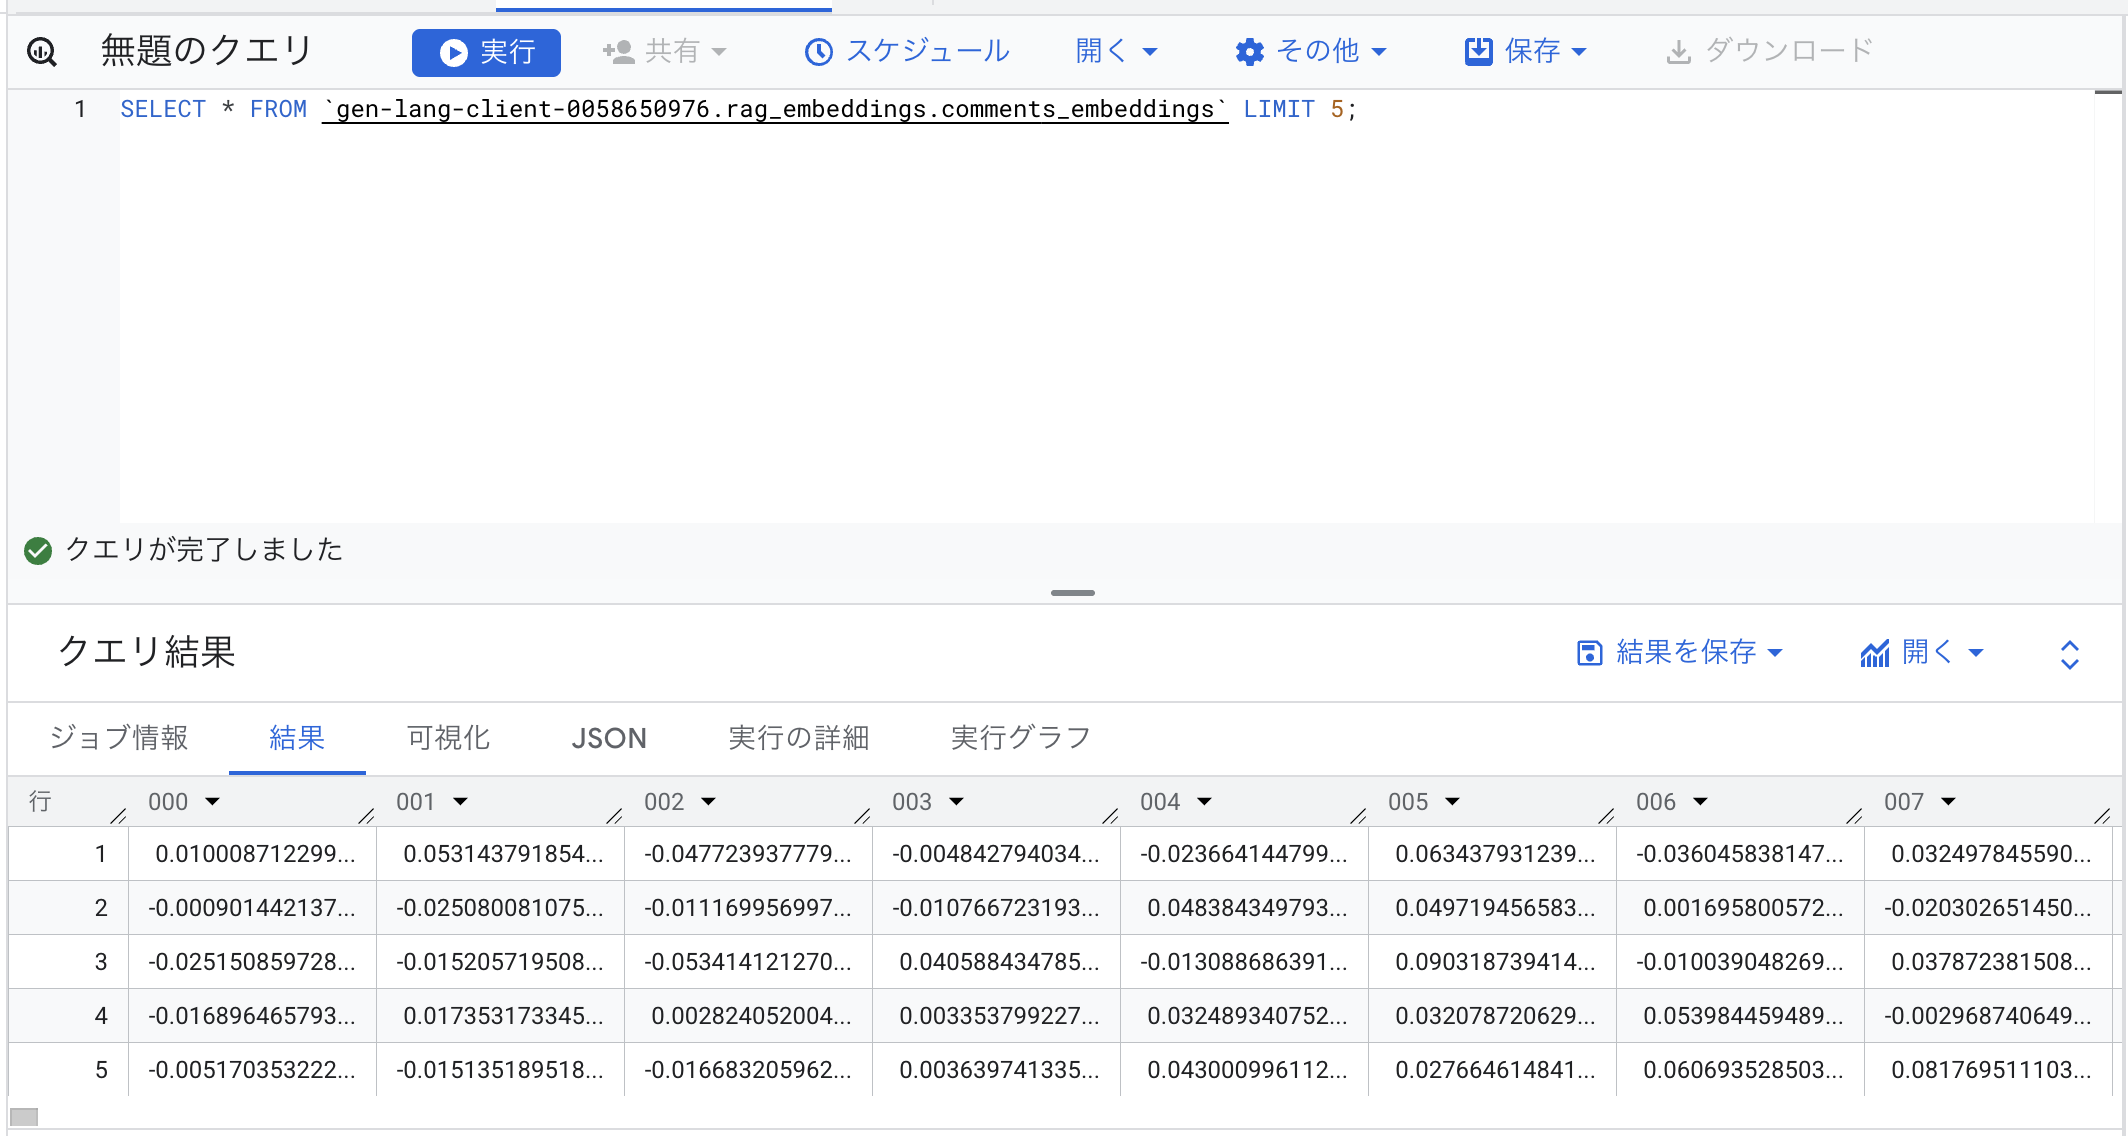

In [210]:
import gcsfs
from PIL import Image
from IPython.display import display

gcs_path = "gs://rag-practice-bucket/埋め込みの保存確認.png"  # バケットに追加したのを表示する

fs = gcsfs.GCSFileSystem()
with fs.open(gcs_path, "rb") as f:
    img = Image.open(f)
    display(img)

In [211]:
# array版
import pandas as pd
from pandas_gbq import to_gbq

# === ARRAY<FLOAT64> 形式に整形 ===
arr_df = pd.DataFrame({
    "clean_text": emb_df["clean_text"].astype(str),
    "embedding": emb_df.drop(columns="clean_text").values.tolist()
})

# === BigQuery へ保存 ===
PROJECT_ID = "gen-lang-client-0058650976"
TABLE_ID = "rag_embeddings_array.comments_embeddings_arr"  

to_gbq(
    arr_df,
    destination_table=TABLE_ID,
    project_id=PROJECT_ID,
    if_exists="replace",
    location="asia-northeast1"
)

print(f"✅ BigQuery に保存しました: {TABLE_ID} ({arr_df.shape})")

100%|██████████| 1/1 [00:00<00:00, 7738.57it/s]

✅ BigQuery に保存しました: rag_embeddings_array.comments_embeddings_arr ((8382, 2))


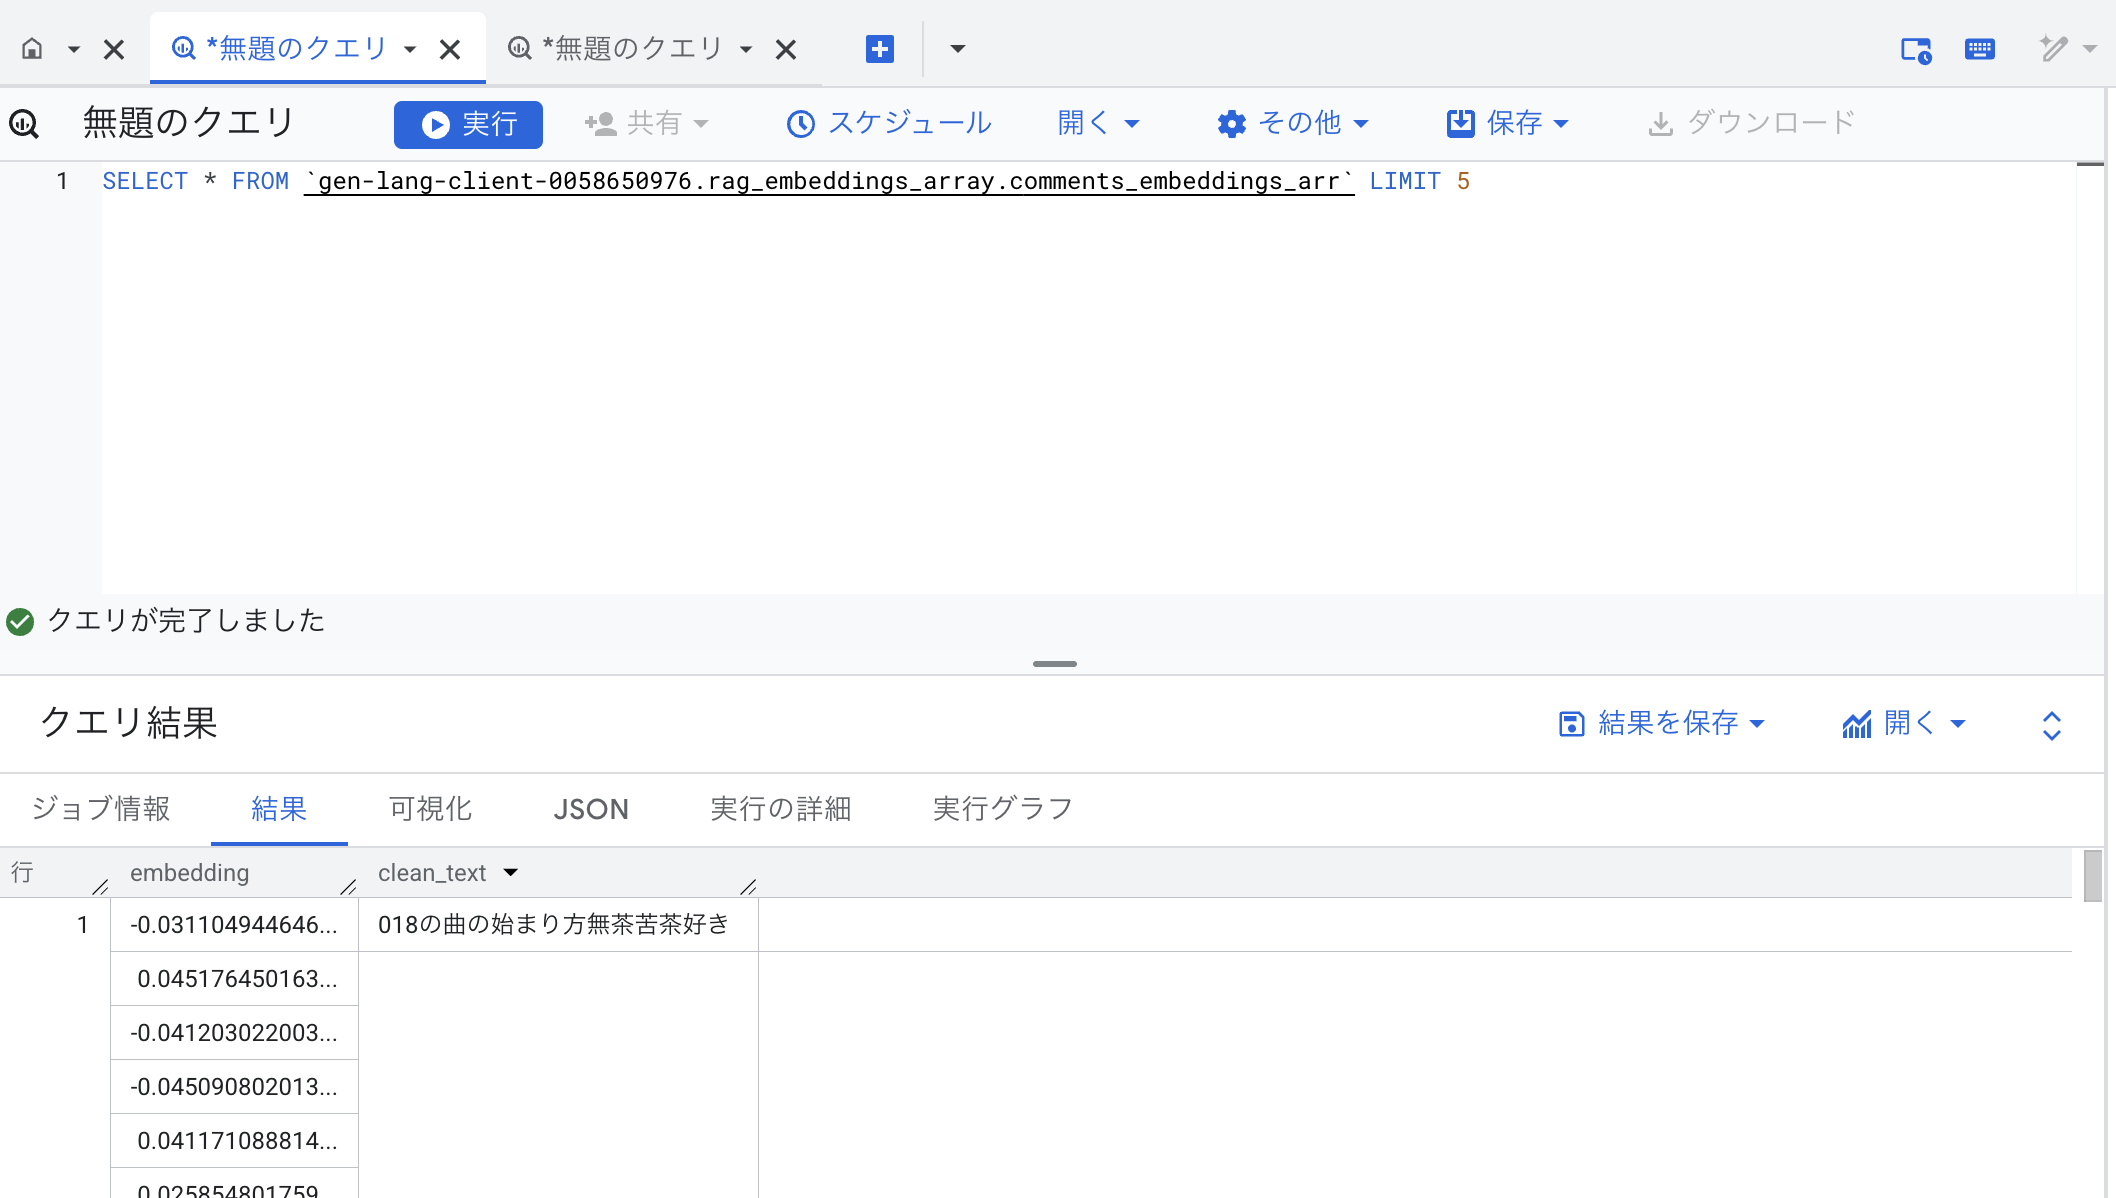

In [212]:
import gcsfs
from PIL import Image
from IPython.display import display

gcs_path = "gs://rag-practice-bucket/埋め込みの保存確認(arr).png"  # バケットに追加したのを表示する

fs = gcsfs.GCSFileSystem()
with fs.open(gcs_path, "rb") as f:
    img = Image.open(f)
    display(img)

## BigQuery 上で類似コメント検索と生成モデル応答

In [236]:
# =========================
# BigQuery 類似検索 + Gemini応答（修正版）
# =========================
PROJECT_ID  = "gen-lang-client-0058650976"
TABLE_FQN   = f"{PROJECT_ID}.rag_embeddings_array.comments_embeddings_arr"
BQ_LOCATION = "asia-northeast1"

import numpy as np
import pandas as pd
from google.cloud import bigquery
from vertexai import init
from vertexai.language_models import TextEmbeddingModel
from vertexai.generative_models import GenerativeModel

# Vertex AI 初期化（Gemini は us-central1 にしかない）
init(project=PROJECT_ID, location="us-central1")

bq     = bigquery.Client(project=PROJECT_ID)
embed  = TextEmbeddingModel.from_pretrained("text-embedding-004")
gemini = GenerativeModel("gemini-2.5-flash")

# --- クエリをベクトル化 ---
def _qvec(text):
    v = embed.get_embeddings([text])[0].values
    return np.asarray(v, dtype=np.float64)

# --- 類似コメント検索 ---
def retrieve_similar(query, k=8, limit=10000):
    q = _qvec(query)

    sql = f"""
      SELECT clean_text, embedding
      FROM `{TABLE_FQN}`
      WHERE ARRAY_LENGTH(embedding) = {len(q)}
      LIMIT @limit
    """
    job = bq.query(
        sql,
        location=BQ_LOCATION,
        job_config=bigquery.QueryJobConfig(
            query_parameters=[bigquery.ScalarQueryParameter("limit", "INT64", limit)]
        ),
    )
    df = job.result().to_dataframe()
    if df.empty:
        print("⚠️ BigQueryにデータがありません")
        return df

    # テキスト整形と重複除去
    df["clean_text"] = df["clean_text"].astype(str).str.strip()
    df = df[(df["clean_text"] != "")].drop_duplicates(subset=["clean_text"])
    if df.empty:
        print("⚠️ 有効なコメントがありません")
        return df

    # --- 類似度計算（cos 類似度をそのまま使用）---
    vecs = np.asarray(df["embedding"].tolist(), dtype=np.float64)
    vnorm = np.linalg.norm(vecs, axis=1, keepdims=True)
    qnorm = np.linalg.norm(q)
    mask = (vnorm[:, 0] > 0) & (qnorm > 0)
    if not mask.any():
        print("⚠️ ベクトルが全てゼロです")
        return pd.DataFrame(columns=["clean_text", "score"])

    v  = vecs[mask] / (vnorm[mask] + 1e-12)
    qn = q / (qnorm + 1e-12)
    sims = np.clip(v @ qn, -1.0, 1.0)  # -1〜1の範囲
    out = pd.DataFrame({
        "clean_text": df.loc[mask, "clean_text"].values,
        "score": sims.astype(float)
    }).sort_values("score", ascending=False).head(k).reset_index(drop=True)

    return out

# --- Gemini応答生成 ---
def rag_answer(query, k=8):
    hits = retrieve_similar(query, k=k)
    if hits.empty:
        print("近いコメントが見つかりません。")
        return

    context = "\n".join(f"- {t}" for t in hits["clean_text"])
    prompt = f"""以下はYouTubeコメントの抜粋です。
この内容を参考にして、質問に対する自然な要約を日本語で答えてください。

コンテキスト:
{context}

質問: {query}
"""

    resp = gemini.generate_content(prompt)

    print("=== 応答 ===\n", resp.text.strip(), "\n")

    print("=== 参考コメント ===")
    for i, (t, s) in enumerate(zip(hits["clean_text"], hits["score"]), 1):
        print(f"{i:>2}. {t[:80]} | sim={s:.6f}")

# --- テスト ---
rag_answer("最近のおすすめの曲は？")

/opt/conda/lib/python3.10/site-packages/vertexai/_model_garden/_model_garden_models.py:278: UserWarning: This feature is deprecated as of June 24, 2025 and will be removed on June 24, 2026. For details, see https://cloud.google.com/vertex-ai/generative-ai/docs/deprecations/genai-vertexai-sdk.
  warning_logs.show_deprecation_warning()
/opt/conda/lib/python3.10/site-packages/vertexai/generative_models/_generative_models.py:433: UserWarning: This feature is deprecated as of June 24, 2025 and will be removed on June 24, 2026. For details, see https://cloud.google.com/vertex-ai/generative-ai/docs/deprecations/genai-vertexai-sdk.
  warning_logs.show_deprecation_warning()


=== 応答 ===
 このコメント群からは、特定の「最近のおすすめの曲」を直接的に推薦することはできません。しかし、「いい曲ですね。聴き入ってしまいます」という感想が寄せられていることから、コメントの対象となっている曲は、聴く人によっては心に残る一曲となるかもしれません。 

=== 参考コメント ===
 1. これのフルないですか？ | sim=1.000000
 2. なんでこんなにたもりの声がきこえるんだろ？ | sim=1.000000
 3. なぜ再生数こんな少ない？ | sim=1.000000
 4. なぜにバナナ？ | sim=1.000000
 5. オープニングでヒーハーゆーてます? | sim=1.000000
 6. いい曲ですね。聴き入ってしまいます。物思いにふけて聴いてます。今聴いてる方いますか？ | sim=1.000000
 7. レスポールじゃ無いでしょ？ | sim=1.000000
 8. 意味は？ | sim=1.000000


## ここまででやった流れを整理する
1. Vertex AIで埋め込み生成 → YouTubeコメントをベクトル化して768次元の数値化。
2. BigQueryに保存 → embedding（数値配列）＋ clean_text（元のコメント）を格納。
3. Python側で検索処理　→ ユーザー入力を同じモデルでベクトル化　→ BigQueryからembeddingを取ってコサイン距離を計算、近いコメントを表示。


## 検証結果のまとめ

#### 現状の確認
- テーブル結合（pandas）
- コメントデータと動画情報の結合はpandasで実施。
- キー整合・件数ともに一致しておりDataFrameの統合自体は正常に完了している。
- その後のBigQueryへの保存処理にも異常は確認されなかった。
#### データクリーニングの影響
- 正規表現によるノイズ除去を強く行った結果、宣伝文やハッシュタグ、短文が大幅に削除され、
- コメント内容の多様性が失われた可能性が高い。似通った「好意的な一文」のみが残存している。
#### 埋め込みベクトルの特性
- text-embedding-004によるベクトル生成は正常（768次元・分散／normともに適正）。
- ただし、好意的コメントの偏りによりベクトルが同一方向に密集し、類似度が均一化した。
#### データ取得・計算経路
- BigQueryからのベクトル取得、正規化、コサイン類似度計算は正常に動作。
- 取り出し時に破損している可能性は低い。

### 結論

- コ-ドやモデルの不具合ではなく、データ分布の偏りが主因。
- クリーニング後のコメントが単調化したことで、距離計算の有効性が失われている。
- 本件は技術的な問題ではなく構造的限界によるものと判断し、検証を終了する。